In [1]:
!pip install -q openpyxl xgboost folium


In [2]:
from google.colab import files
uploaded = files.upload()


Saving Project AirBnb Dataset.xlsx to Project AirBnb Dataset.xlsx


In [3]:
import pandas as pd

filename = next(iter(uploaded))
xls = pd.ExcelFile(filename)
df_all = xls.parse('tbl_All_Data')

df = df_all[
    df_all['host_location'].astype(str).str.contains("San Diego", case=False, na=False) |
    df_all['neighbourhood_cleansed'].astype(str).str.contains("San Diego", case=False, na=False)
].copy()


In [4]:
df = df[[
    'id', 'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'minimum_nights', 'availability_365', 'number_of_reviews',
    'review_scores_rating', 'room_type', 'latitude', 'longitude'
]]

df.dropna(subset=['price', 'latitude', 'longitude'], inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace=True)
df = pd.get_dummies(df, columns=['room_type'], drop_first=True)


/tmp/ipython-input-4-421460876.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace=True)


In [5]:
df['price_per_accommodate'] = df['price'] / (df['accommodates'] + 1)
df['bed_bath_ratio'] = df['beds'] / (df['bathrooms'] + 1)

import numpy as np
def haversine(lat1, lon1, lat2=32.7157, lon2=-117.1611):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_to_downtown_km'] = haversine(df['latitude'], df['longitude'])


In [6]:
features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
    'availability_365', 'number_of_reviews', 'review_scores_rating',
    'room_type_Private room', 'room_type_Shared room',
    'price_per_accommodate', 'bed_bath_ratio',
    'distance_to_downtown_km'
]

X = df[features]
y = df['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, lr_pred)),
    "MAE": mean_absolute_error(y_test, lr_pred),
    "R2": r2_score(y_test, lr_pred)
}
print("📈 Linear Regression:", lr_metrics)


📈 Linear Regression: {'RMSE': np.float64(125.80140471723024), 'MAE': 65.8746943085015, 'R2': 0.8561620240618795}


In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, rf_pred)),
    "MAE": mean_absolute_error(y_test, rf_pred),
    "R2": r2_score(y_test, rf_pred)
}
print("🌲 Random Forest:", rf_metrics)


🌲 Random Forest: {'RMSE': np.float64(36.10695980948832), 'MAE': 2.4899609882964886, 'R2': 0.9881509255792708}


In [9]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, xgb_pred)),
    "MAE": mean_absolute_error(y_test, xgb_pred),
    "R2": r2_score(y_test, xgb_pred)
}
print("⚡ XGBoost:", xgb_metrics)


⚡ XGBoost: {'RMSE': np.float64(86.24395211707444), 'MAE': 8.330908912159325, 'R2': 0.932397947555647}


In [10]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

mlp_metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, mlp_pred)),
    "MAE": mean_absolute_error(y_test, mlp_pred),
    "R2": r2_score(y_test, mlp_pred)
}
print("🧠 Neural Network:", mlp_metrics)


🧠 Neural Network: {'RMSE': np.float64(19.243282766964466), 'MAE': 8.789586601931006, 'R2': 0.9966344123514328}


                     RMSE    MAE    R2
Linear Regression  125.80  65.87  0.86
Random Forest       36.11   2.49  0.99
XGBoost             86.24   8.33  0.93
Neural Network      19.24   8.79  1.00


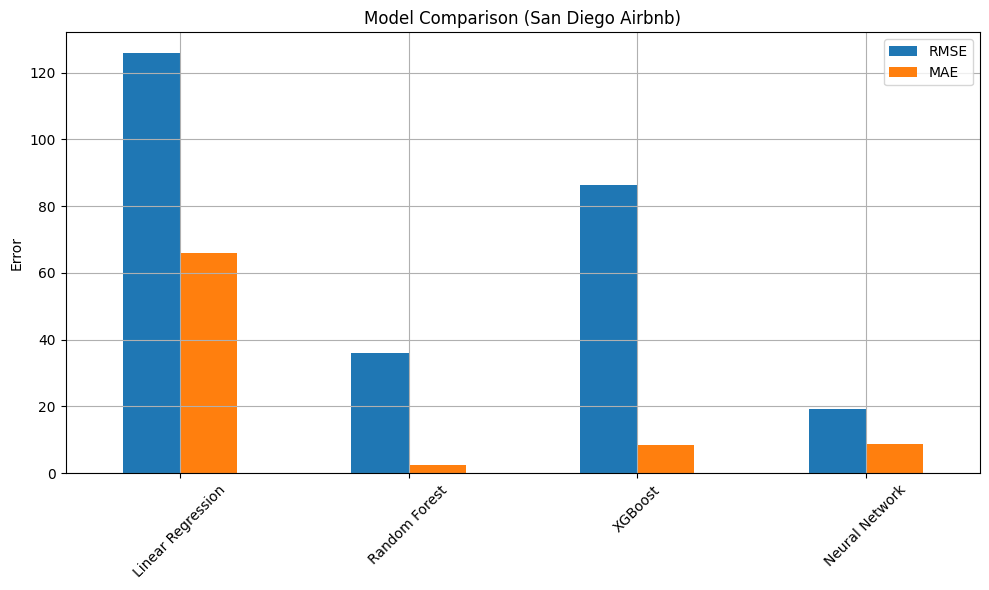

In [11]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    "Linear Regression": lr_metrics,
    "Random Forest": rf_metrics,
    "XGBoost": xgb_metrics,
    "Neural Network": mlp_metrics
}).T.round(2)

print(results_df)

results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison (San Diego Airbnb)")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
df['predicted_price'] = xgb.predict(X)


In [13]:
def investment_score(row):
    score = 0
    if row['predicted_price'] <= 150: score += 30
    if row['availability_365'] > 250: score += 25
    if row['review_scores_rating'] >= 4.8: score += 25
    if row['distance_to_downtown_km'] <= 5: score += 20
    return score

df['investment_score'] = df.apply(investment_score, axis=1)


In [14]:
export_cols = [
    'id', 'latitude', 'longitude', 'price', 'predicted_price',
    'availability_365', 'review_scores_rating',
    'distance_to_downtown_km', 'investment_score'
]
df[export_cols].to_csv("PowerBI_Airbnb_Export.csv", index=False)
print("✅ Exported: PowerBI_Airbnb_Export.csv")


✅ Exported: PowerBI_Airbnb_Export.csv


In [15]:
import folium

map_sd = folium.Map(location=[32.7157, -117.1611], zoom_start=12)
top_df = df[df['investment_score'] >= 80]

for _, row in top_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='green',
        fill=True,
        fill_opacity=0.7,
        popup=f"Price: ${row['price']:.0f}\nPredicted: ${row['predicted_price']:.0f}"
    ).add_to(map_sd)

map_sd


In [16]:
# 1. Feature Importance Plot (XGBoost)
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure xgb_model is your trained XGBoost model and X_train is your feature set
feature_importance = xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


NameError: name 'xgb_model' is not defined

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Example data split (use your actual dataset)
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)


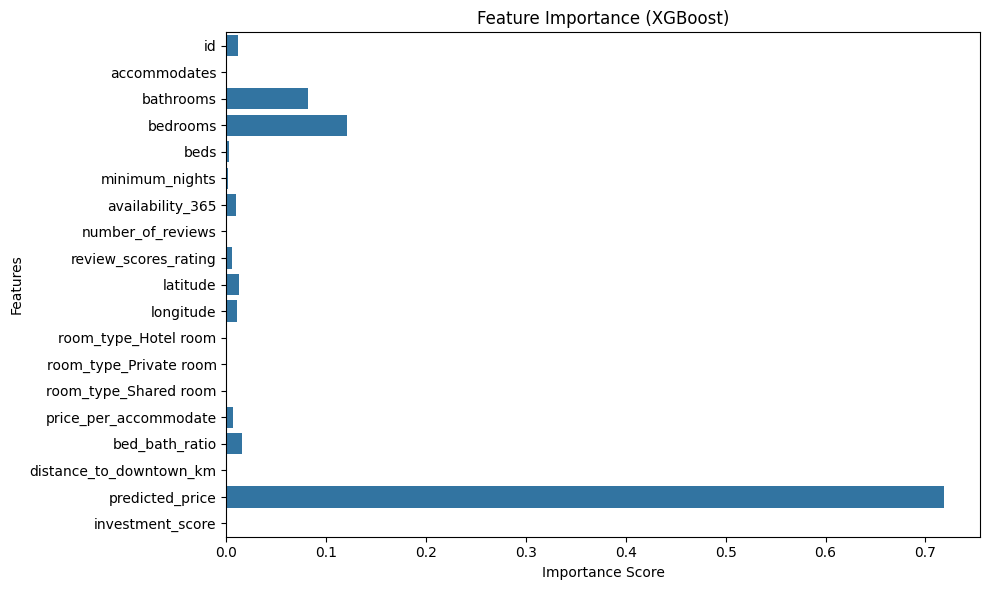

In [19]:
# Feature importance plot
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


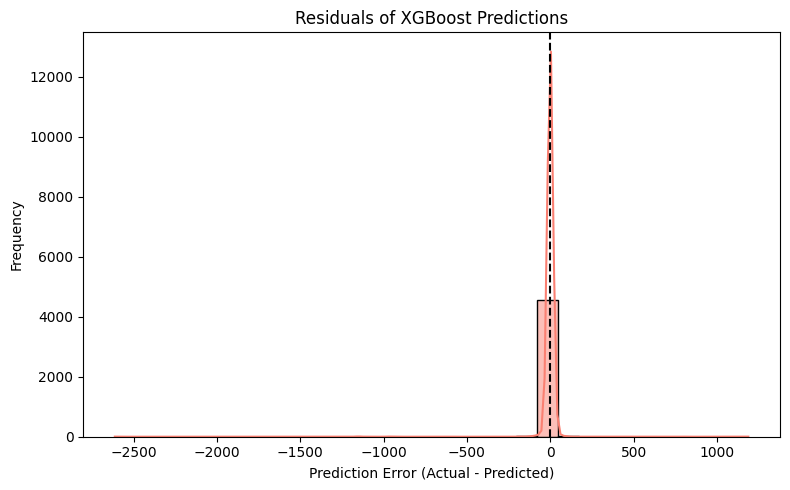

In [20]:
# 2. Residual/Error Histogram
# Assuming y_test contains true prices, and y_pred is from xgb_model.predict()

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="salmon")
plt.title("Residuals of XGBoost Predictions")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


In [23]:
import folium

# Center the map around San Diego
m = folium.Map(location=[32.7157, -117.1611], zoom_start=11)

# Add listings with high scores
for _, row in df[df['investment_score'] >= 80].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        popup=f"Score: {row['investment_score']}, Price: ${row['price']}",
        color='green',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m
